In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
import os

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange
try:
    import cv2
except:
    %pip install opencv-python
    import cv2



In [6]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !curl https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -o dog.jpg

dog.jpg exists


torch.Size([3, 1365, 2048])


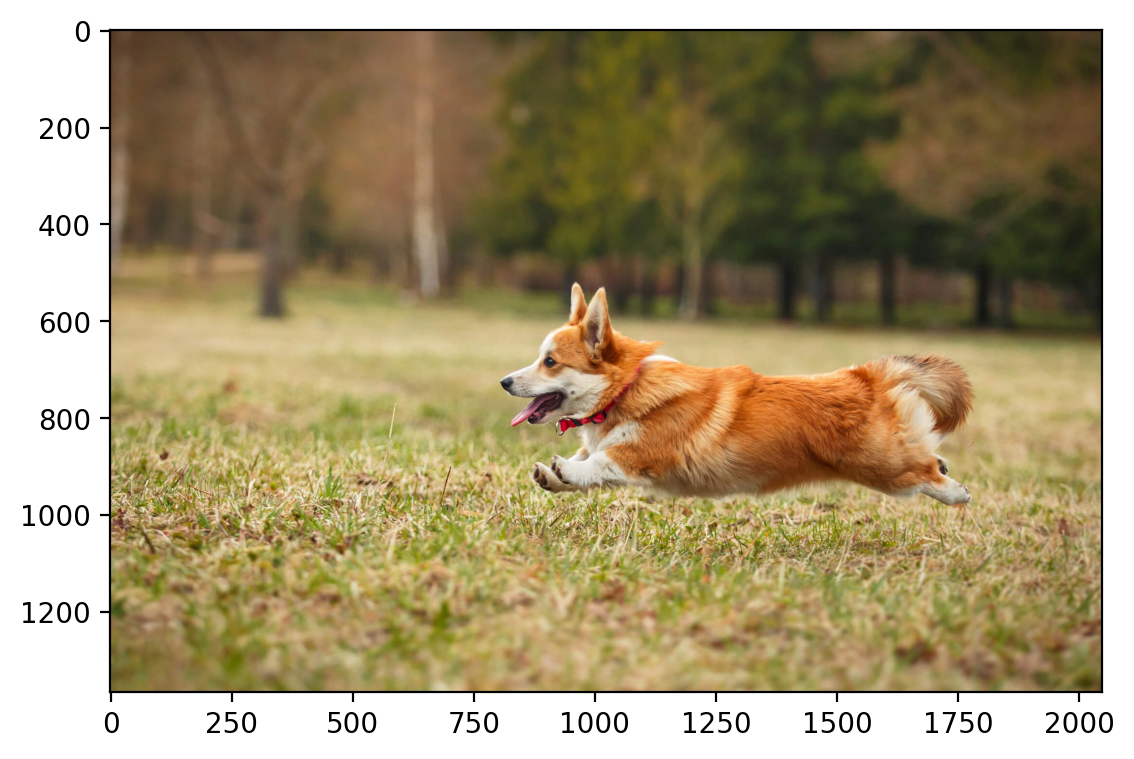

In [7]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [8]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

(3, 1365, 2048)


tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

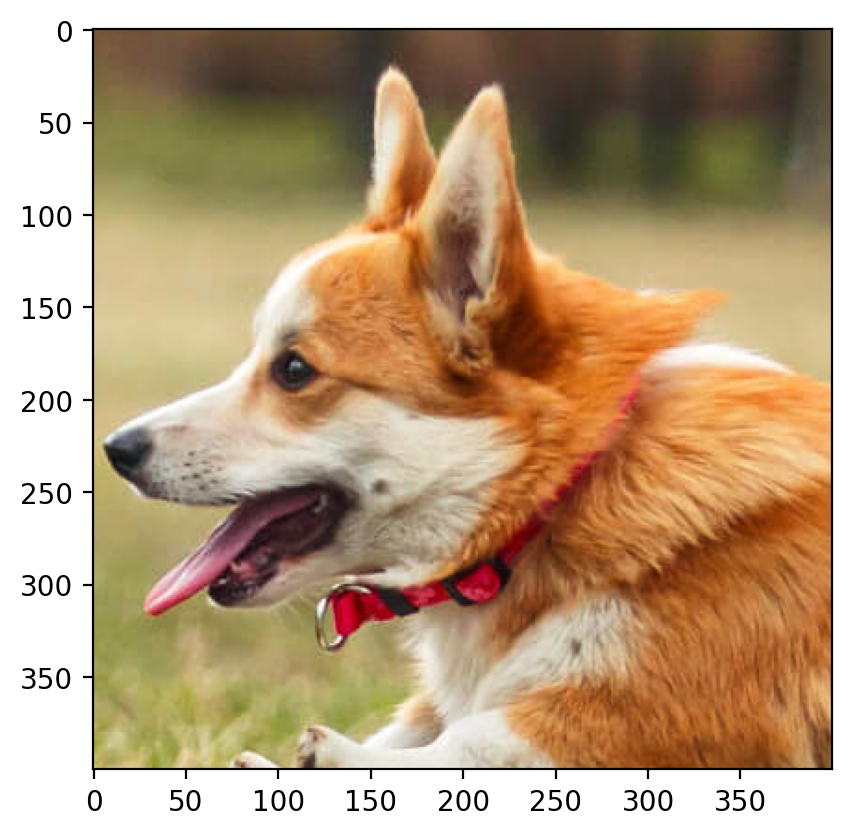

In [9]:
crop_400 = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 800, 400, 400)
crop_400_downscaled = rearrange(torch.from_numpy(cv2.resize(rearrange(crop_400, 'c h w -> h w c').numpy(), (200, 200), interpolation=cv2.INTER_LINEAR)), 'h w c -> c h w')
plt.imshow(rearrange(crop_400, 'c h w -> h w c'))

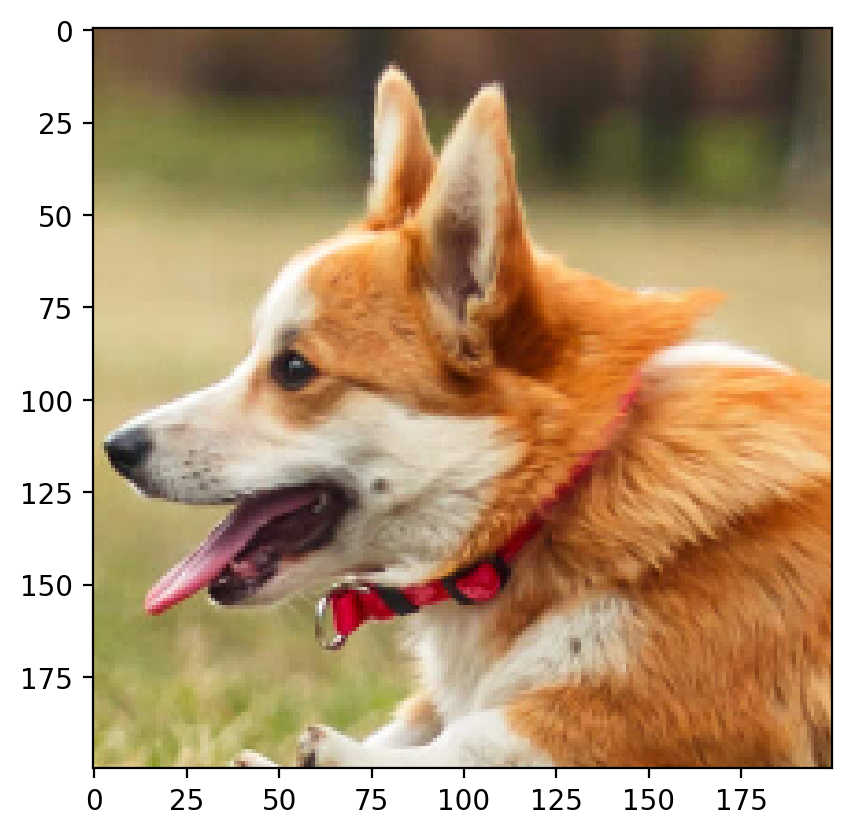

In [10]:
plt.imshow(rearrange(crop_400_downscaled, 'c h w -> h w c'))

In [50]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

def scale_coordinates(dog_X):        
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

    # Scale the X coordinates
    dog_X_scaled = scaler_X.transform(dog_X.cpu())

    # Move the scaled X coordinates to the GPU
    dog_X_scaled = torch.tensor(dog_X_scaled)

    # Set to dtype float32
    dog_X_scaled = dog_X_scaled.float()

    return dog_X_scaled, scaler_X

def create_rff_features(X, num_features, sigma, seed=42):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=seed)
    X_rff = torch.tensor(rff.fit_transform(X.cpu().numpy()), dtype=torch.float32).to(device)
    return X_rff

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs

def rmse(t1 : torch.Tensor, t2: torch.Tensor) -> float:
    return torch.sum((t1-t2)**2)/torch.numel(t1)

def psnr(t1 : torch.Tensor, t2: torch.Tensor) -> float:
    return  10*torch.log10(1/rmse(t1, t2))

In [12]:
dog_X, dog_Y = create_coordinate_map(crop_400_downscaled, scale=1)
x_test, _ = (create_coordinate_map(crop_400, scale=1))
x_test = x_test/2
x_test.shape

torch.Size([160000, 2])

In [27]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
#dog_X_scaled = scale_coordinates(dog_X)
try:
    del(dog_x_train); del(dog_x_test)
except:
    pass

In [28]:
dog_x_train = create_rff_features(dog_X_scaled, 20000, 0.008, seed = 42)
dog_x_test = create_rff_features(torch.tensor(scaler_X.transform(x_test.cpu())).to(device).float(), 20000, 0.008, seed = 42)
# torch.save(dog_x_train, 'ES335-MLAssignment2/dog_x_train.pt')
# torch.save(dog_x_test, 'ES335-MLAssignment2/dog_x_test.pt')
print(dog_x_train.shape)
print(dog_x_test.shape)

torch.Size([40000, 20000])
torch.Size([160000, 20000])


In [ ]:
# torch.load(dog_x_train, 'ES335-MLAssignment2/dog_x_train.pt')
# torch.load(dog_x_test, 'ES335-MLAssignment2/dog_x_test.pt')

In [29]:
net = LinearModel(dog_x_train.shape[1], 3)
net.to(device)
train(net, 0.005, dog_x_train.to(device), dog_Y.to(device), 2000)
torch.save(net.state_dict(),'dog_model.pt')

Epoch 0 loss: 0.313467
Epoch 100 loss: 0.041151
Epoch 200 loss: 0.013291
Epoch 300 loss: 0.008102
Epoch 400 loss: 0.005537
Epoch 500 loss: 0.004031
Epoch 600 loss: 0.003101
Epoch 700 loss: 0.002493
Epoch 800 loss: 0.002068
Epoch 900 loss: 0.001750
Epoch 1000 loss: 0.001497
Epoch 1100 loss: 0.001289
Epoch 1200 loss: 0.001113
Epoch 1300 loss: 0.000964
Epoch 1400 loss: 0.000838
Epoch 1500 loss: 0.000732
Epoch 1600 loss: 0.000642
Epoch 1700 loss: 0.000568
Epoch 1800 loss: 0.000507
Epoch 1900 loss: 0.000458


In [30]:
net = LinearModel(dog_x_train.shape[1], 3)
net.load_state_dict(torch.load('dog_model.pt', weights_only=True))
net.eval()

LinearModel(
  (linear): Linear(in_features=20000, out_features=3, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


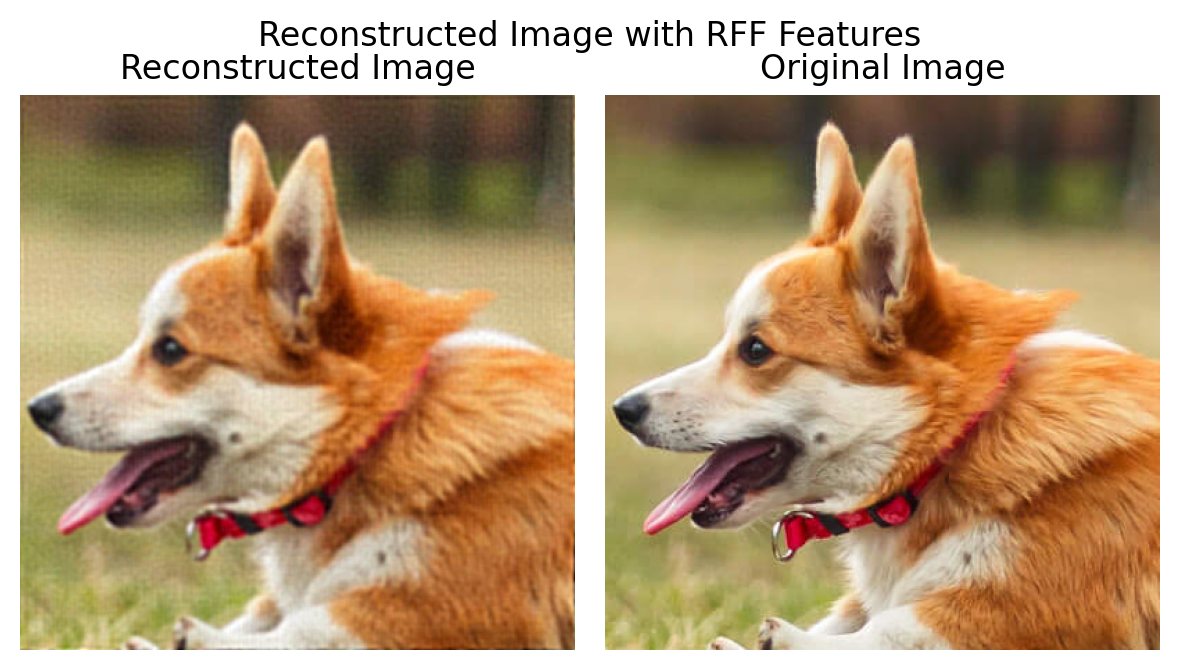

In [34]:
reconstructed_image = plot_reconstructed_and_original_image(crop_400.to(device), net.to(device), dog_x_test.to(device), title="Reconstructed Image with RFF Features")

tensor([[[0.4721, 0.3549, 0.2455],
         [0.4303, 0.3090, 0.2160],
         [0.4431, 0.3206, 0.2196],
         ...,
         [0.3592, 0.2936, 0.2151],
         [0.4483, 0.3668, 0.2217],
         [0.6984, 0.5689, 0.2682]],

        [[0.4941, 0.3551, 0.2389],
         [0.4469, 0.3183, 0.2204],
         [0.4549, 0.3331, 0.2301],
         ...,
         [0.3052, 0.2453, 0.1977],
         [0.3833, 0.3143, 0.2083],
         [0.6148, 0.5060, 0.2520]],

        [[0.4849, 0.3421, 0.2165],
         [0.4347, 0.3036, 0.1952],
         [0.4360, 0.3126, 0.2025],
         ...,
         [0.3226, 0.2640, 0.2132],
         [0.3918, 0.3251, 0.2279],
         [0.5962, 0.4913, 0.2626]],

        ...,

        [[0.8132, 0.7921, 0.4668],
         [0.7840, 0.7703, 0.4182],
         [0.7787, 0.7527, 0.3986],
         ...,
         [0.5526, 0.3902, 0.1860],
         [0.5806, 0.4230, 0.2266],
         [0.5926, 0.4442, 0.2832]],

        [[0.8227, 0.7881, 0.5051],
         [0.7670, 0.7491, 0.4345],
         [0.

In [51]:
# Here is the Root mean square error:
print(rmse(reconstructed_image.to(device), rearrange(crop_400, 'c h w -> h w c').to(device)))
# Here is the Peak signal to noise ratio:
print(psnr(reconstructed_image.to(device), rearrange(crop_400, 'c h w -> h w c').to(device)))

tensor(0.0010, device='cuda:0', dtype=torch.float64)
tensor(29.8276, device='cuda:0', dtype=torch.float64)
